In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from utils import plot_tree_boundaries

features = ['age','acutephysiologyscore']
outcome = 'actualhospitalmortality'

data = pd.read_csv('eicu_processed.csv')

x = data[features]
y = data[outcome]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state =  42)

# Boosting

In the previous episode, we demonstrated that decision trees may have high “variance”. Their performance can vary widely given different samples of data. An algorithm that performs somewhat poorly at a task - such as simple decision tree - is sometimes referred to as a “weak learner”.

The premise of boosting is the combination of many weak learners to form a single “strong” learner. In a nutshell, boosting involves building a models iteratively. At each step we focus on the data on which we performed poorly.

In our context, the first step is to build a tree using the data. Next, we look at the data that we misclassified, and re-weight the data so that we really wanted to classify those observations correctly, at a cost of maybe getting some of the other data wrong this time. Let’s see how this works in practice.

To begin, we must first create a version of our dataset without NaNs - the type of boosting classifier we will be using is not able to deal with missing data.

In [2]:
# Fill missing data with -1
data_no_nans = data.fillna(-1)

x = data_no_nans[features]
y = data_no_nans[outcome]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state =  42)

We can now take a look at how boosting works.

**Task:** Use [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) to train a boosted decision tree with 6 estimators, where the `base_estimator` is a `DecisionTreeClassifier` with `max_depth=1`.

/home/matthew/.virtualenvs/intro-to-trees/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/matthew/.virtualenvs/intro-to-trees/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/matthew/intro-to-trees/utils.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/home/matthew/.virtualenvs/intro-to-trees/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/matthew/intro-to-trees/utils.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/home/matthew/.virtualenvs/intro-to-trees/lib/python3.10/site-packages/sklearn/

<Figure size 1200x1200 with 0 Axes>

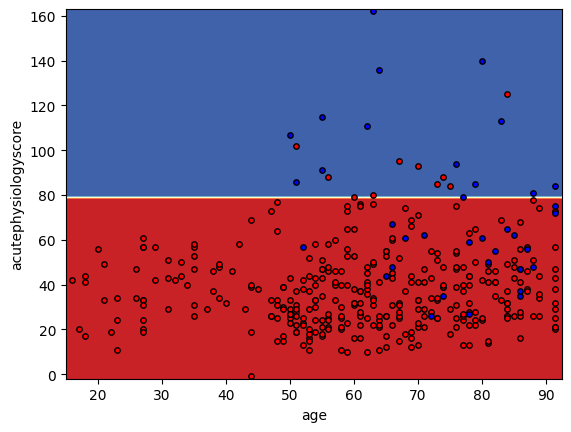

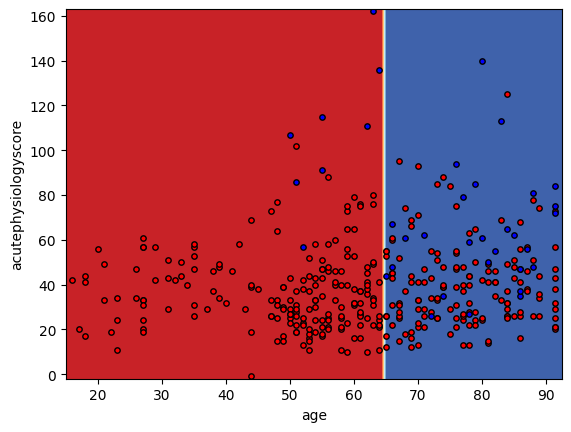

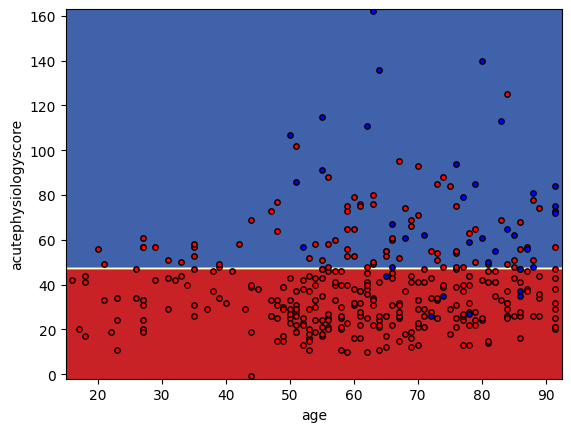

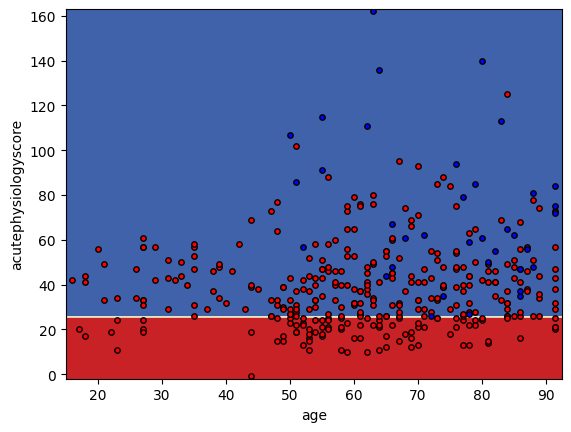

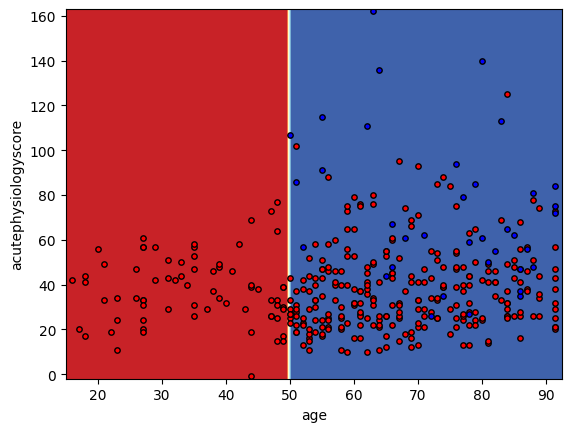

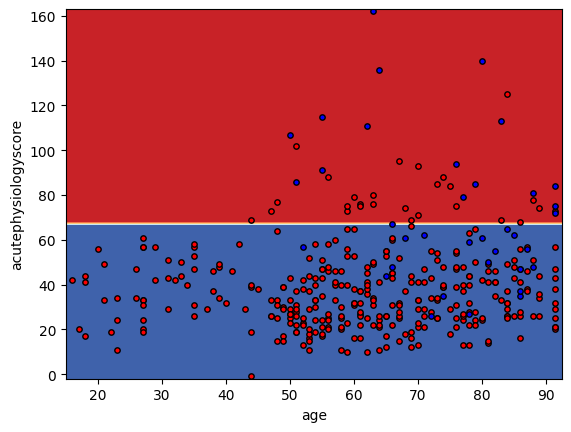

In [3]:
from sklearn import ensemble
from sklearn import tree
import matplotlib.pyplot as plt

# build models with a single split
base_model = 
model =
model = model.fit(x_train, y_train)

# plot each individual decision tree
plt.figure(figsize=(12, 12))
for i, estimator in enumerate(model.estimators_):
    plot_tree_boundaries(estimator, x_train, y_train, feature_names=features, 
                                  target_names=['Alive', 'Dead'])

By inspecting how the decision boundary each time, we can see how incorrectly classified samples are being weighted differently.

**Question:** Does the first tree in the collection (the one in the top left) look familiar to you? Why?

In the second tree we can see the model shift. It misclassified several observations in class 1, and now these are the most important observations. Consequently, it picks the boundary that, while prioritizing correctly classifies these observations, still tries to best classify the rest of the data too. The iteration process continues until the model may be creating boundaries to capture just one or two observations.

One important point is that each tree is weighted by its global error. So, for example, Tree 6 would carry less weight in the final model. It is clear that we wouldn’t want Tree 6 to carry the same importance as Tree 1, when Tree 1 is doing so much better overall. It turns out that weighting each tree by the inverse of its error is a pretty good way to do this.

Let’s look at the decision surface of the final ensemble.

/home/matthew/intro-to-trees/utils.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


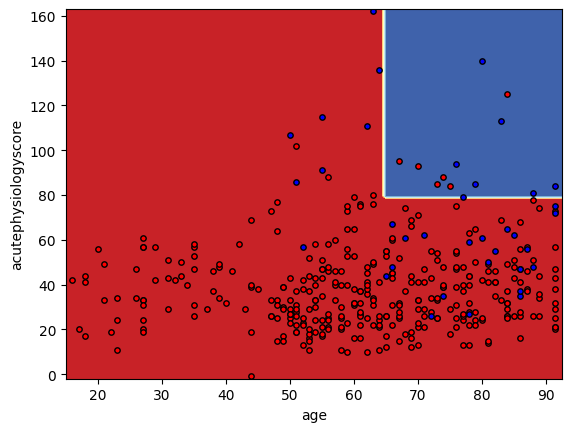

In [4]:
plot_tree_boundaries(model, x_train, y_train, feature_names=features, target_names=['Alive', 'Dead'])

And that’s AdaBoost! There are a few tricks we have glossed over here, but you understand the general principle. We modified the data to focus on hard to classify observations. We can imagine this as a form of data resampling for each new tree.

For example, say we have three observations: A, B, and C, [A, B, C]. If we correctly classify observations [A, B], but incorrectly classify C, then AdaBoost involves building a new tree that focuses on C.

Equivalently, we could say AdaBoost builds a new tree using the dataset [A, B, C, C, C], where we have intentionally repeated observation C 3 times so that the algorithm thinks it is 3 times as important as the other observations. Makes sense?

Now we’ll move on to a different approach that also involves manipulating data to build new trees.